## Description

Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

##### Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

## Data Dictionary

|Column name|Description|Data type|
|-----------|-----------|---------|
|date_time|Timestamp|string|
|site_name|ID of the Expedia point of sale(i.e.Expedia.com,Expedia.co.uk, Expedia.co.jp, ...)|int|
|posa_continent|ID of continent associated with site_name|int|
|user_location_country|The ID of the country the customer is located|int|
|user_location_region|The ID of the region the customer is located|int|
|user_location_city|The ID of the city the customer is located	|int|
|orig_destination_distance|Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated|float|
|user_id|ID of user|int|
|is_mobile|1 when a user connected from a mobile device, 0 otherwise|int|
|is_package|1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise|int|
|channel|ID of a marketing channel|int|
|srch_ci|Checkin date|string|
|srch_co|Checkout date|string|
|srch_adults_cnt|The number of adults specified in the hotel room|int|
|srch_children_cnt|The number of (extra occupancy) children specified in the hotel room|int|
|srch_rm_cnt|The number of hotel rooms specified in the search	|int|
|srch_destination_id|ID of the destination where the hotel search was performed|int|
|srch_destination_type_id|Type of destination|int|
|hotel_continent|Hotel continent|int|
|hotel_country|Hotel country|int|
|hotel_market|Hotel market|int|
|is_booking|1 if a booking, 0 if a click|int|
|cnt|Numer of similar events in the context of the same user session|int|
|hotel_cluster|ID of a hotel cluster|int|

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.cross_validation import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
expedia = pd.read_csv("../../Datasets/Expedia Data/train.csv", nrows=20000)

In [3]:
expedia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 24 columns):
date_time                    20000 non-null object
site_name                    20000 non-null int64
posa_continent               20000 non-null int64
user_location_country        20000 non-null int64
user_location_region         20000 non-null int64
user_location_city           20000 non-null int64
orig_destination_distance    11868 non-null float64
user_id                      20000 non-null int64
is_mobile                    20000 non-null int64
is_package                   20000 non-null int64
channel                      20000 non-null int64
srch_ci                      19988 non-null object
srch_co                      19988 non-null object
srch_adults_cnt              20000 non-null int64
srch_children_cnt            20000 non-null int64
srch_rm_cnt                  20000 non-null int64
srch_destination_id          20000 non-null int64
srch_destination_type_id     20000 n

In [4]:
expedia.head(3)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1


In [5]:
exp = pd.DataFrame(expedia)

In [6]:
exp['date_time'] = pd.to_datetime(exp['date_time'])
exp['srch_ci'] = pd.to_datetime(exp['srch_ci'])
exp['srch_co'] = pd.to_datetime(exp['srch_co'])

66     11016
69      2067
205     1386
3        897
46       829
23       398
70       276
62       228
77       194
231      189
Name: user_location_country, dtype: int64


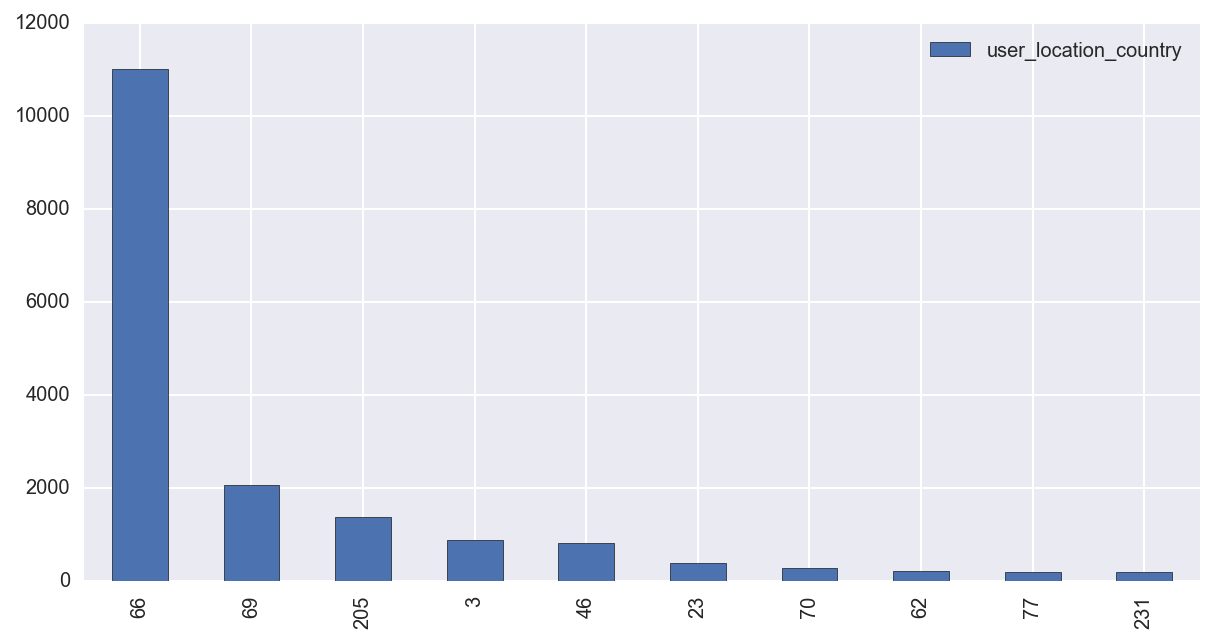

In [8]:
# What country are most of the searches from?

print exp['user_location_country'].value_counts().head(10)

plt.figure(figsize=(10,5))
exp['user_location_country'].value_counts().head(10).plot(legend=True, kind='bar')

In [12]:
# Booked subset
booked = exp[exp['is_booking'] == 1]

0    18421
1     1579
Name: is_booking, dtype: int64


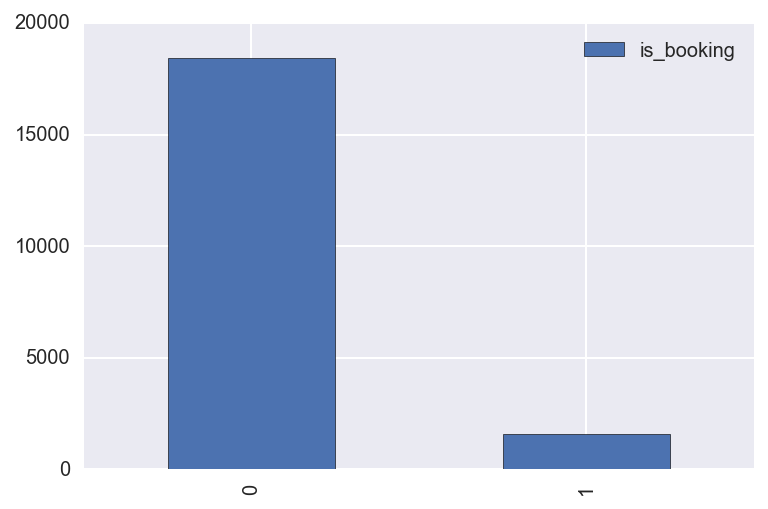

In [9]:
# How many bookings?

print exp['is_booking'].value_counts()
exp['is_booking'].value_counts().plot(legend=True, kind='bar')

0    15013
1     4987
Name: is_package, dtype: int64


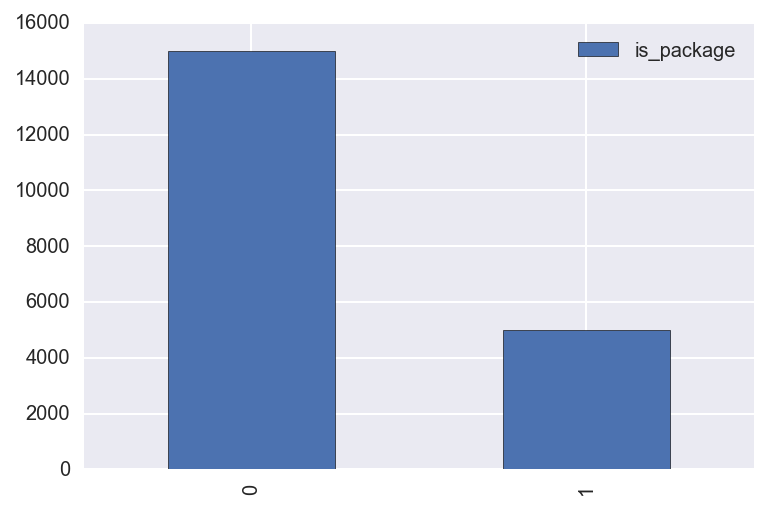

In [11]:
# Packages
# Packages booked packages

print exp['is_package'].value_counts()
exp['is_package'].value_counts().plot(legend=True, kind='bar')

0    16840
1     3160
Name: is_mobile, dtype: int64


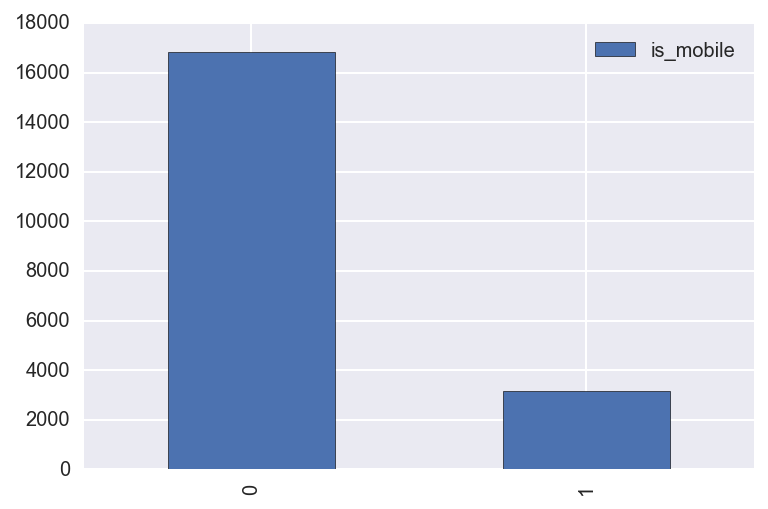

In [13]:
# Mobile
# booked Mobile
# booked mobile, that is a package

print exp['is_mobile'].value_counts()
exp['is_mobile'].value_counts().plot(legend=True, kind='bar')

In [14]:
exp2 = exp.copy()

exp2.drop(exp2[['date_time', 'srch_ci', 'srch_co', 'channel', 
                'orig_destination_distance', 'hotel_cluster']], axis=1, inplace=True)

In [61]:
X_cols = exp2.columns
X = exp2[X_cols].values
Y = expedia.hotel_cluster.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Baseline Accuracy

In [18]:
from scipy.stats import mode
modearray = mode(Y)
print modearray

ModeResult(mode=array([91]), count=array([476]))


In [19]:
baseline = modearray[1][0]/float(Y.shape[0])
print "baseline score: ", baseline

baseline score:  0.0238


# Modeling

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

# Decision Tree

In [21]:
dtc = DecisionTreeClassifier()

In [22]:
dtc_params = {
    'criterion':['gini','entropy'],
    'max_features':['auto', None],
    'max_depth':[None,3,4,5],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf':[1,3,5,7]
}

dtc_gs = GridSearchCV(dtc, dtc_params, cv=5, verbose=2, n_jobs=-1)

In [62]:
dtc_gs.fit(X_train, Y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 754 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:   24.8s finished


[CV] max_features=auto, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=1 
[CV] max_features=auto, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=1 
[CV] max_features=auto, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=1 
[CV] max_features=auto, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=1 -   0.1s[CV]  max_features=auto, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=1 -   0.1s[CV]  max_features=auto, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=1 -   0.1s[CV]  max_features=auto, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=1 -   0.1s



[CV] max_features=auto, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=1 
[CV] max_features=auto, min_samples_split=3, criterion=gini, max_depth=None, min_samples_le

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', None], 'min_samples_split': [2, 3, 4, 5], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 3, 4, 5], 'min_samples_leaf': [1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

[CV] max_features=None, min_samples_split=5, criterion=gini, max_depth=None, min_samples_leaf=1 
[CV] max_features=None, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=3 

[CV] max_features=None, min_samples_split=3, criterion=gini, max_depth=None, min_samples_leaf=3 
[CV]  max_features=None, min_samples_split=5, criterion=gini, max_depth=None, min_samples_leaf=1 -   0.2s[CV]  max_features=None, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=3 -   0.1s[CV] max_features=None, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=3 
[CV]  max_features=None, min_samples_split=3, criterion=gini, max_depth=None, min_samples_leaf=3 -   0.1s

[CV]  max_features=None, min_samples_split=2, criterion=gini, max_depth=None, min_samples_leaf=3 -   0.1s
[CV] max_features=None, min_samples_split=5, criterion=gini, max_depth=None, min_samples_leaf=1 
[CV] max_features=None, min_samples_split=2, criterion=gini, max_depth=None, min_samples_le

In [68]:
print dtc_gs.best_estimator_
print "\n-------------------------\n"
print dtc_gs.best_params_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

-------------------------

{'max_features': None, 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}


In [69]:
dtc_best = dtc_gs.best_estimator_.fit(X_train, Y_train)

In [70]:
dtc_best.score(X_test, Y_test)

0.25733333333333336

In [32]:
pd.DataFrame({'feature':X_cols, 'importance':dtc_best.feature_importances_}).sort_values(by='importance', 
                                                                                         ascending=False)

,feature,importance
17,hotel_market,0.218093
15,hotel_continent,0.118275
5,user_id,0.104529
4,user_location_city,0.092541
11,srch_destination_id,0.083800
3,user_location_region,0.080483
16,hotel_country,0.069440
14,cnt,0.058260
12,srch_destination_type_id,0.034475
8,srch_adults_cnt,0.028933


# Random Forest

In [33]:
rf = RandomForestClassifier()

In [34]:
rf_params = {
    'n_estimators':[10,20,30],
    'criterion':['gini','entropy'],
    'max_features':['auto',None],
    'max_depth':[None,2,3,4,5]
}

rf_gs = GridSearchCV(rf, rf_params, cv=5, verbose=2, n_jobs=-1)

In [71]:
rf_gs.fit(X_train, Y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


[CV] max_features=auto, n_estimators=10, criterion=gini, max_depth=None 
[CV] max_features=auto, n_estimators=10, criterion=gini, max_depth=None 
[CV] max_features=auto, n_estimators=10, criterion=gini, max_depth=None 
[CV] max_features=auto, n_estimators=10, criterion=gini, max_depth=None 
[CV]  max_features=auto, n_estimators=10, criterion=gini, max_depth=None -   0.6s[CV]  max_features=auto, n_estimators=10, criterion=gini, max_depth=None -   0.6s[CV]  max_features=auto, n_estimators=10, criterion=gini, max_depth=None -   0.6s[CV]  max_features=auto, n_estimators=10, criterion=gini, max_depth=None -   0.6s



[CV] max_features=auto, n_estimators=10, criterion=gini, max_depth=None 
[CV] max_features=auto, n_estimators=20, criterion=gini, max_depth=None 
[CV] max_features=auto, n_estimators=20, criterion=gini, max_depth=None 
[CV] max_features=auto, n_estimators=20, criterion=gini, max_depth=None 
[CV]  max_features=auto, n_estimators=10, criterion=gini, max_depth=None -   0.6s[CV]  m

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30], 'max_features': ['auto', None], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

[CV] max_features=auto, n_estimators=10, criterion=gini, max_depth=4 .


[CV]  max_features=auto, n_estimators=10, criterion=gini, max_depth=3 -   0.1s[CV]  max_features=auto, n_estimators=10, criterion=gini, max_depth=4 -   0.2s[CV] max_features=auto, n_estimators=20, criterion=gini, max_depth=3 .
[CV] max_features=auto, n_estimators=30, criterion=gini, max_depth=4 .


[CV]  max_features=auto, n_estimators=20, criterion=gini, max_depth=3 -   0.3s[CV]  max_features=auto, n_estimators=30, criterion=gini, max_depth=4 -   0.5s[CV] max_features=auto, n_estimators=20, criterion=gini, max_depth=3 .
[CV] max_features=auto, n_estimators=20, criterion=gini, max_depth=4 .


[CV]  max_features=auto, n_estimators=20, criterion=gini, max_depth=3 -   0.3s[CV]  max_features=auto, n_estimators=20, criterion=gini, max_depth=4 -   0.3s[CV] max_features=auto, n_estimators=30, criterion=gini, max_depth=3 .
[CV] max_features=None, n_estimators=10, criterion=gini, max_depth=4 .


[CV]  max_features=auto, n_

In [82]:
print rf_gs.best_estimator_
print "\n--------------------------\n"
print rf_gs.best_params_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

--------------------------

{'max_features': None, 'n_estimators': 30, 'criterion': 'gini', 'max_depth': None}


In [73]:
rf_best = rf_gs.best_estimator_
rf_best.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [74]:
rf_best.score(X_test, Y_test)

0.28533333333333333

# K Nearest Neighbor

In [44]:
knn = KNeighborsClassifier()

In [53]:
# hone in on parameters
knn_params = {
    'n_neighbors':range(15,30,1), # tuning from 2,30
    'weights':['uniform','distance'],
    'algorithm':['ball_tree','kd_tree','brute'],
    'metric':['euclidean','manhattan']
}

knn_gs = GridSearchCV(knn, knn_params, cv=5, verbose=2, n_jobs=-1)

In [75]:
knn_gs.fit(X_train, Y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.9min finished


[CV] n_neighbors=15, metric=euclidean, weights=uniform, algorithm=ball_tree 
[CV] n_neighbors=15, metric=euclidean, weights=uniform, algorithm=ball_tree 
[CV] n_neighbors=15, metric=euclidean, weights=uniform, algorithm=ball_tree 
[CV] n_neighbors=15, metric=euclidean, weights=uniform, algorithm=ball_tree 
[CV]  n_neighbors=15, metric=euclidean, weights=uniform, algorithm=ball_tree -   0.3s[CV]  n_neighbors=15, metric=euclidean, weights=uniform, algorithm=ball_tree -   0.3s[CV]  n_neighbors=15, metric=euclidean, weights=uniform, algorithm=ball_tree -   0.4s[CV]  n_neighbors=15, metric=euclidean, weights=uniform, algorithm=ball_tree -   0.3s



[CV] n_neighbors=15, metric=euclidean, weights=distance, algorithm=ball_tree 
[CV] n_neighbors=15, metric=euclidean, weights=distance, algorithm=ball_tree 
[CV] n_neighbors=15, metric=euclidean, weights=distance, algorithm=ball_tree 
[CV] n_neighbors=15, metric=euclidean, weights=uniform, algorithm=ball_tree 
[CV]  n_neighbors=15, metric=euclidea

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'metric': ['euclidean', 'manhattan'], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

[CV]  n_neighbors=23, metric=euclidean, weights=uniform, algorithm=ball_tree -   0.4s[CV]  n_neighbors=23, metric=euclidean, weights=distance, algorithm=ball_tree -   0.4s[CV]  n_neighbors=23, metric=euclidean, weights=distance, algorithm=ball_tree -   0.4s[CV]  n_neighbors=23, metric=euclidean, weights=distance, algorithm=ball_tree -   0.4s



[CV] n_neighbors=23, metric=euclidean, weights=distance, algorithm=ball_tree 
[CV] n_neighbors=24, metric=euclidean, weights=uniform, algorithm=ball_tree 
[CV] n_neighbors=24, metric=euclidean, weights=uniform, algorithm=ball_tree 
[CV] n_neighbors=23, metric=euclidean, weights=distance, algorithm=ball_tree 
[CV]  n_neighbors=23, metric=euclidean, weights=distance, algorithm=ball_tree -   0.4s[CV]  n_neighbors=24, metric=euclidean, weights=uniform, algorithm=ball_tree -   0.4s[CV]  n_neighbors=24, metric=euclidean, weights=uniform, algorithm=ball_tree -   0.4s[CV]  n_neighbors=23, metric=euclidean, weights=distance, algorithm=ball_tree -   0.4s


In [79]:
print knn_gs.best_estimator_
print "\n---------------------------\n"
print knn_gs.best_params_

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='distance')

---------------------------

{'n_neighbors': 18, 'metric': 'euclidean', 'weights': 'distance', 'algorithm': 'brute'}


In [80]:
knn_best = knn_gs.best_estimator_
knn_best.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='distance')

In [81]:
knn_best.score(X_test, Y_test)

0.27350000000000002